In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm

from inlifesim.statistics import test_dist, get_qq, imb

# 1. Generate and load data
A sample of 1e8 simulated observations with the LIFE setup as secified in Table 1 is generated. These samples are generated using the following code:

```python
import numpy as np
import pandas as pd
from astropy import units as u
from spectres import spectres

import inlifesim as ils

path_spectrum = '/path/to/EarthSpectrum.txt'

earth_twin = {'distance_s': 10,
              'temp_s': 5778.,
              'radius_s': 1.,
              'lat_s': 0.78,
              'l_sun': 1.,
              'z': 1.,
              'temp_p': 254.,
              'radius_p': 1.,
              'sep_p': 1.,}

dbw = {'ap_diameter': 3.,
       'spec_res': 50.,
       't_int': 10 * 24 * 60 * 60,
       'throughput': 0.035,
       't_exp': 60 * 30,
       'n_rot': 1,
       'wl_bin': 10e-6,
       'bl': 14.5,
       'ratio': 6,
       'wl_bin_width': 0.3e-6,
       'rms_mode': 'wavelength',
       'hyperrot_noise': 'zero',
       'd_phi_rms': 0.005,
       'd_a_rms': 0.005,
       'd_x_rms': 0.,
       'd_y_rms': 0.,
       'd_pol_rms': 0.005,
       'd_a_co': 10e3,
       'd_phi_co': 10e3,
       'd_pol_co': 10e3,
       'd_x_co': 0.64e-3,
       'd_y_co': 0.64e-3}

data = pd.read_csv(
    path_spectrum,
    header=None, sep='\s+')

lam_PRT = data[0].values * u.micron
f_PRT = data[1].values * u.erg / u.cm ** 2 / u.s / u.Hz
f_lifesim = f_PRT.to(u.photon / u.m ** 2 / u.s / u.micron, \
                     equivalencies=u.spectral_density(lam_PRT))

f_lifesim = f_lifesim.to(u.photon / u.s / u.meter ** 3)
lam_lifesim = lam_PRT.to(u.meter)

# scale planet flux to distance
f_lifesim *= (10 / earth_twin['distance_s']) ** 2

flux_planet_spectrum = [lam_lifesim, f_lifesim]

flux_planet_spectrum = spectres(
            new_wavs=np.array((dbw['wl_bin'] - dbw['wl_bin_width'] / 2,
                               dbw['wl_bin'] + dbw['wl_bin_width'] / 2)),
            spec_wavs=flux_planet_spectrum[0].value,
            spec_fluxes=flux_planet_spectrum[1].value,
            edge_mode=True
        )

flux_planet_spectrum *= dbw['wl_bin_width']

col_pos = np.array((
                (-dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (-dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2)
            ))

instrument = ils.Instrument(wl_bins=np.array((dbw['wl_bin'], )),
                            wl_bin_widths=np.array((dbw['wl_bin_width'], )),
                            image_size=512,
                            diameter_ap=dbw['ap_diameter'],
                            flux_division=np.array((0.25, 0.25, 0.25, 0.25)),
                            throughput=dbw['throughput'],
                            dist_star=earth_twin['distance_s'],
                            radius_star=earth_twin['radius_s'],
                            temp_star=earth_twin['temp_s'],
                            lat_star=earth_twin['lat_s'],
                            l_sun=earth_twin['l_sun'],
                            z=earth_twin['z'],
                            temp_planet=earth_twin['temp_p'],
                            radius_planet=earth_twin['radius_p'],
                            separation_planet=earth_twin['sep_p'],
                            col_pos=col_pos,
                            phase_response=np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            phase_response_chop=-np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            n_rot=dbw['n_rot'],
                            t_total=dbw['t_int'],
                            t_exp=dbw['t_exp'],
                            n_cpu=80,
                            rms_mode=dbw['rms_mode'],
                            hyperrot_noise=dbw['hyperrot_noise'],
                            n_sampling_max=int(1e7),
                            d_a_rms=dbw['d_a_rms'],
                            d_phi_rms=dbw['d_phi_rms'],
                            d_pol_rms=dbw['d_pol_rms'],
                            d_x_rms=dbw['d_x_rms'],
                            d_y_rms=dbw['d_y_rms'],
                            d_a_co=dbw['d_a_co'],
                            d_phi_co=dbw['d_phi_co'],
                            d_pol_co=dbw['d_pol_co'],
                            d_x_co=dbw['d_x_co'],
                            d_y_co=dbw['d_y_co'],
                            n_draws=int(1e8),
                            n_draws_per_run=int(1e4),
                            time_series_return_values='all_xcorr',
                            flux_planet=flux_planet_spectrum,
                            simultaneous_chopping=True,
                            verbose=True,
                            draw_samples=True,
                            get_single_bracewell=False,
                            instrumental_source=None)
instrument.run()

sample = instrument.time_samples['xcorr_aphi']

np.save('/path/to/samples.npy', sample)
```

The pre-generated data can be downloaded from Zenodo: TODO.
They contain a simulation of the measured photon rate produced by the second order perturbations correlated with the planet template. There are 1e8 values in the array, each represents one estimate of the flux F under these conditions.

In [5]:
sample = np.load(
    '/Users/fdannert/Documents/projects/InLIFEsim/working/paper/FINAL_DATA/x_array_FINAL_1e8_10pc_aphi.npy')

# 2. Find best fitting Degrees of Freedom
The degrees of freedom $\nu$ in a correlated sample are determined by finding the maximum of the coefficient of determination under the IMB distribution.

In [6]:
nconv = np.arange(30, 45, 1, dtype=int)
r2 = []
scale = []
ns = []

for n in tqdm(nconv, desc='Fitting'):
    r2_mod = test_dist(data=sample / np.std(sample),
                       mode='imb',
                       loc=0,
                       scale=1,
                       nconv=n,
                       fit=False,
                       plot=False)
    r2.append(r2_mod)
    ns.append(n)
    # scale.append(scale_mod)

r2 = np.array(r2)
# scale = np.array(scale)

Fitting:   0%|          | 0/15 [00:00<?, ?it/s]

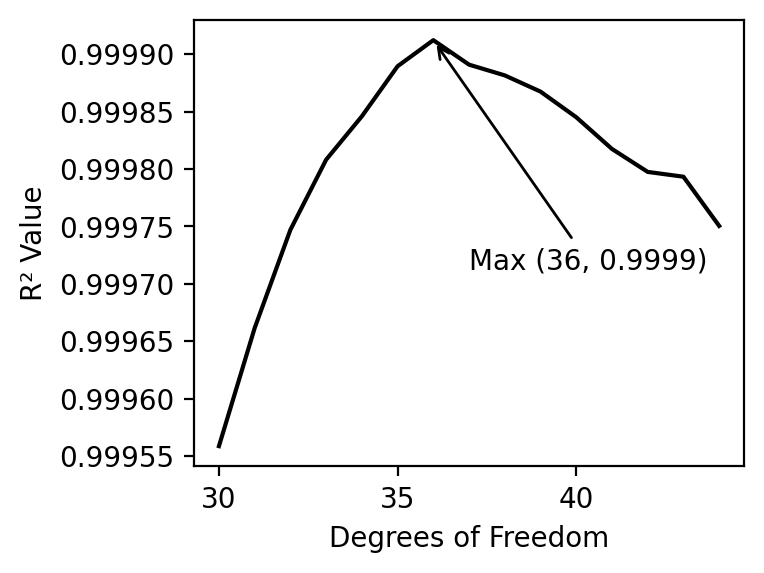

In [7]:
fig, ax = plt.subplots(figsize=(3.55, 2.9), dpi=200)

plt.plot(ns, r2, c='k')
max_r2_idx = np.argmax(r2)
max_ns = ns[max_r2_idx]
ax.annotate(f'Max ({max_ns}, {r2[max_r2_idx]:.4f})',
            xy=(max_ns, r2[max_r2_idx]),
            xytext=(max_ns + 1, r2[max_r2_idx] - 0.0002),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("R² Value")

plt.show()

# 3. Generate Final Plot
The final plot is generated to visualize both the IMB distribution and the data's fit to the standard normal and IMB models.
It consists of two components: 
1. A histogram and PDF comparison on the left, showcasing the normalized data alongside the fitted distributions. 
2. A QQ-plot on the right, displaying the quantile-quantile comparison for the IMB distribution. This allows us to assess the quality of the model fit. 


In [5]:
#Direct input
plt.rcParams['text.latex.preamble']=r'\usepackage{lmodern} \usepackage{amsmath}'

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

In [6]:
# preload the calculation of the qq-plots
setup = {
    'name': ['normal', 'imb_fit', 'imb_low', 'imb_high'],
    'mode': ['normal', 'imb', 'imb', 'imb'],
    'nconv': [None, 36, 10, 100],
    'recalc': [True, True, True, True],
}

data = deepcopy(sample / np.std(sample))

if 'qq_data' not in locals():
    qq_data = {}

for i in range(len(setup['name'])):
    if setup['recalc'][i]:
        q, q_good, q_fail, r_2 = get_qq(data=data,
                                        loc=0,
                                        scale=1,
                                        mode=setup['mode'][i],
                                        nconv=setup['nconv'][i],
                                        siglim=7,
                                        n_eval=100)
        qq_data[setup['name'][i]] = {
            'q': q,
            'q_good': q_good,
            'q_fail': q_fail,
            'r_2': r_2
        }

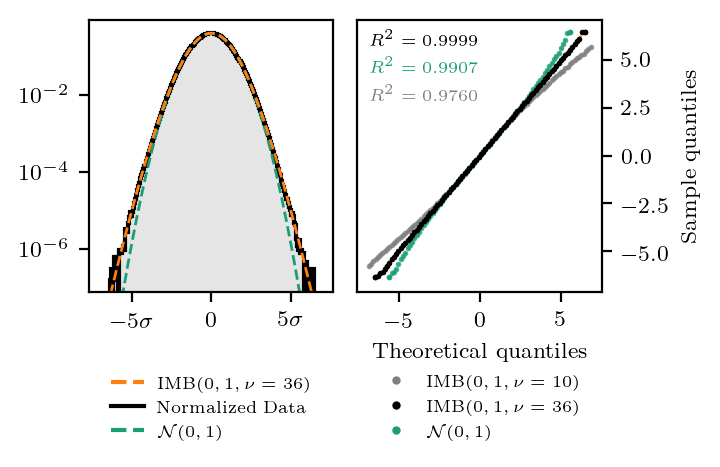

In [7]:
cs = {'data': 'k',
    'imb': 'tab:orange', #'#d95f02',
      'normal': '#1b9e77'
}

fig, ax = plt.subplots(ncols=2, figsize=(3.55, 2.9), dpi=200)

# ----- histogram -----
siglim = 7
n_eval_pdf = 1000
q_theo = np.linspace(-siglim, siglim, n_eval_pdf)
lw = 1.5

ax_qq = ax[0]
ax_pdf = ax[1]

hist = ax_qq.hist(data, # / np.std(data),
                    bins=200,
                    density=True,
                    color=cs['data'],
                    alpha=0.1,
                    histtype=u'stepfilled',
                    lw=lw)

hist = ax_qq.hist(data, # / np.std(data),
                    bins=200,
                    density=True,
                    color=cs['data'],
                    histtype=u'step',
                    lw=lw)

pdf = stats.norm.pdf(x=q_theo, loc=0, scale=1)
ax_qq.plot(q_theo,
              pdf,
              color=cs['normal'],
              ls='--',
              lw=lw-0.5,
              alpha=1)


dist = imb(loc=0, scale=1, n=setup['nconv'][1])
pdf = dist.pdf(x=q_theo)
ax_qq.plot(q_theo,
              pdf,
              color=cs['imb'],
              ls='--',
              lw=lw-0.5,
              alpha=1)

ax_qq.set_yscale('log')
ax_qq.set_ylim(np.sort(np.unique(hist[0]))[1] * 0.5,
                  np.max(np.concatenate((hist[0], pdf))) * 1.5)

ax_qq.set_xticks([-5, 0, 5], ['$-5\sigma$', '0', '$5\sigma$'])

# ----- imb distribution qq-plot -----
name = 'imb_fit'
s = 1

lim = np.max(np.concatenate((np.abs(qq_data[name]['q']['theo']),
                             np.abs(qq_data[name]['q']['sample']))))


ax_pdf.plot([-lim, lim], [-lim, lim],
              color=cs['imb'], lw=lw-0.5, ls='--', zorder=0)

ax_pdf.scatter(qq_data[name]['q_good']['theo'],
                 qq_data[name]['q_good']['sample'],
                 color=cs['data'],
                 alpha=1,
                 s=s,
              zorder=2)

ax_pdf.scatter(qq_data['imb_low']['q_good']['theo'],
                 qq_data['imb_low']['q_good']['sample'],
                 color='gray',
                 alpha=0.8,
                 s=s,
              zorder=1)

ax_pdf.scatter(qq_data['normal']['q_good']['theo'],
                 qq_data['normal']['q_good']['sample'],
                 color=cs['normal'],
                 alpha=0.8,
                 s=s,
              zorder=1)

ax_pdf.set_xlabel('Theoretical quantiles')
ax_pdf.set_ylabel('Sample quantiles')

# plot the r2 values as text in the ax 0
ax_pdf.text(0.05, 0.95, f'$R^2 = {qq_data["imb_fit"]["r_2"]:.4f}$',
              transform=ax_pdf.transAxes,
           color=cs['data'],
              fontsize=6,
              verticalalignment='top',
              horizontalalignment='left')

ax_pdf.text(0.05, 0.85, f'$R^2 = {qq_data["normal"]["r_2"]:.4f}$',
              transform=ax_pdf.transAxes,
           color=cs['normal'],
              fontsize=6,
              verticalalignment='top',
              horizontalalignment='left')

ax_pdf.text(0.05, 0.75, f'$R^2 = {qq_data["imb_low"]["r_2"]:.4f}$',
              transform=ax_pdf.transAxes,
           color='gray',
              fontsize=6,
              verticalalignment='top',
              horizontalalignment='left')

legend_labels_qq = [
    r'$\mathrm{IMB}(0, 1, \nu = 10)$',
    r'$\mathrm{IMB}(0, 1, \nu = 36)$',
    r'$\mathcal{N}(0, 1)$'
]
legend_labels_pdf = [
    r'$\mathrm{IMB}(0, 1, \nu = 36)$',
    'Normalized Data',
    r'$\mathcal{N}(0, 1)$'
]
legend_colors = [cs['data'], cs['imb'], cs['normal']]

ax_pdf.legend(handles=[
    plt.Line2D([0], [0], color='gray', lw=0, ls='-', marker='o', markersize=2),
    plt.Line2D([0], [0], color=cs['data'], lw=0, ls='-', marker='o', markersize=2),
    plt.Line2D([0], [0], color=cs['normal'], lw=0, ls='-', marker='o', markersize=2),
],
    labels=legend_labels_qq,
    loc='lower center',  # Position the legend below the plot
    ncol=1,  # Number of columns
    bbox_to_anchor=(0.5, -0.6),  # Adjust the anchor point for the legend
    frameon=False,
    fontsize=6)

ax_qq.legend(handles=[
                    plt.Line2D([0], [0], color=cs['imb'], lw=1.5, ls='--'),
    plt.Line2D([0], [0], color=cs['data'], lw=1.5, ls='-'),
                    plt.Line2D([0], [0], color=cs['normal'], lw=1.5, ls='--')
                    ],
           labels=legend_labels_pdf,
           loc='lower center',  # Position the legend below the plot
           ncol=1,  # Number of columns
           bbox_to_anchor=(0.5, -0.6),  # Adjust the anchor point for the legend
           frameon=False,
           fontsize=6)

ax_pdf.yaxis.tick_right()
ax_pdf.yaxis.set_label_position("right")

ax_qq.set_ylim(ax_qq.get_ylim()[0], ax_qq.get_ylim()[1] * 1.5)

# plt.subplots_adjust(bottom=1)
plt.tight_layout()

plt.show()